## Market Segmentation
## Data Analyst : Woojin Park
## M.S. in Business Intelligence & Data Analytics at Carnegie Mellon Universtiy
## Email : woojinpa@andrew.cmu.edu

###  Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly.figure_factory as ff
from plotly.figure_factory._county_choropleth import create_choropleth

In [2]:
%ls

95-851 Sp20 HW4 - Market segmentation using k-means.pdf
Homework4_WoojinPark.ipynb
bikes.xlsx
bikeshops.xlsx
orders.xlsx


### Read xlsx file into pandas dataframe

In [3]:
bike_df= pd.read_excel('bikes.xlsx')
shop_df= pd.read_excel('bikeshops.xlsx')
order_df= pd.read_excel('orders.xlsx', index_col=0)

In [4]:
bike_df.head(3)

,bike.id,model,category1,category2,frame,price
0,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,12790
1,2,Supersix Evo Hi-Mod Team,Road,Elite Road,Carbon,10660
2,3,Supersix Evo Hi-Mod Dura Ace 1,Road,Elite Road,Carbon,7990


In [5]:
shop_df.head(3)

,bikeshop.id,bikeshop.name,bikeshop.city,bikeshop.state,latitude,longitude
0,1,Pittsburgh Mountain Machines,Pittsburgh,PA,40.440625,-79.995886
1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881
2,3,Columbus Race Equipment,Columbus,OH,39.961176,-82.998794


In [6]:
order_df.head(3)

,order.id,order.line,order.date,customer.id,product.id,quantity
1,1,1,2011-01-07,2,48,1
2,1,2,2011-01-07,2,52,1
3,2,1,2011-01-10,10,76,1


## Step 1: Data preprocessing

###  First, you will load all three datasets (bikes, bikeshops, and orders) and merge them together into one single data frame for further analysis. Remember, you can link the three datasets together by using the product.id and customer.id in the orders table.

In [7]:
# orders.xlsx contains the actual order histories with the manufacturer Cannondale. 
# Note, in orders.xlsx, customer.id refers to the IDs of bikeshops who ordered the bike
# and the product.id refers to the IDs of specific bike models.

In [8]:
order_shop = order_df.merge(shop_df, left_on='customer.id', right_on='bikeshop.id', how = 'left')

In [9]:
order_shop_bike = order_shop.merge(bike_df, left_on ='product.id', right_on= 'bike.id', how='left')

In [10]:
order_shop_bike.describe()

,order.id,order.line,customer.id,product.id,quantity,bikeshop.id,latitude,longitude,bike.id,price
count,15644.000000,15644.000000,15644.000000,15644.000000,15644.000000,15644.000000,15644.000000,15644.000000,15644.000000,15644.000000
mean,997.953081,8.471619,13.458195,49.475326,1.289440,13.458195,37.942601,-95.049026,49.475326,3521.110969
std,569.694443,6.816723,7.716678,28.231556,0.884835,7.716678,4.591913,13.423425,28.231556,2667.194590
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.761680,-122.676482,1.000000,415.000000
25%,520.000000,3.000000,8.000000,25.000000,1.000000,8.000000,35.467560,-104.990251,25.000000,1840.000000
50%,985.500000,7.000000,10.000000,48.000000,1.000000,10.000000,39.114053,-94.627464,48.000000,2700.000000
75%,1490.000000,13.000000,19.000000,75.000000,1.000000,19.000000,40.440625,-83.743038,75.000000,4260.000000
max,2000.000000,30.000000,30.000000,97.000000,10.000000,30.000000,47.606209,-71.412834,97.000000,12790.000000


In [11]:
order_shop_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15643
Data columns (total 18 columns):
order.id          15644 non-null int64
order.line        15644 non-null int64
order.date        15644 non-null datetime64[ns]
customer.id       15644 non-null int64
product.id        15644 non-null int64
quantity          15644 non-null int64
bikeshop.id       15644 non-null int64
bikeshop.name     15644 non-null object
bikeshop.city     15644 non-null object
bikeshop.state    15644 non-null object
latitude          15644 non-null float64
longitude         15644 non-null float64
bike.id           15644 non-null int64
model             15644 non-null object
category1         15644 non-null object
category2         15644 non-null object
frame             15644 non-null object
price             15644 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(8), object(7)
memory usage: 2.3+ MB


### Next, convert the unit price to categorical high/low variables. To do this, you can divide the unit prices into two halves using the median as the split point.

In [12]:
order_shop_bike['price'].median()

2700.0

In [13]:
new_price = [] 
for value in order_shop_bike['price']: 
    if value >= order_shop_bike['price'].median(): 
        new_price.append("High") 
    else: 
        new_price.append("Low") 
order_shop_bike["price_category"] = new_price    

In [14]:
order_shop_bike.tail(3)

,order.id,order.line,order.date,customer.id,product.id,quantity,bikeshop.id,bikeshop.name,bikeshop.city,bikeshop.state,latitude,longitude,bike.id,model,category1,category2,frame,price,price_category
15641,2000,6,2015-12-25,15,17,1,15,Austin Cruisers,Austin,TX,30.267153,-97.743061,17,CAAD12 105,Road,Elite Road,Aluminum,1680,Low
15642,2000,7,2015-12-25,15,70,1,15,Austin Cruisers,Austin,TX,30.267153,-97.743061,70,F-Si Carbon 4,Mountain,Cross Country Race,Carbon,2880,High
15643,2000,8,2015-12-25,15,61,1,15,Austin Cruisers,Austin,TX,30.267153,-97.743061,61,Scalpel-Si 5,Mountain,Cross Country Race,Aluminum,3200,High


### Spread the bikeshops by quantity of bike models purchased. To do this, you can group the data by model & model features (‘bikeshop.name', 'model', 'category1', 'category2', 'frame', 'price') and summarize by quantity purchased. Then, you can use a pivot table to allocate the aggregated quantities across different bikeshops. This transforms the data frame from one in which each row is an order from a bikeshop for a model, to one in which each row is a model, and one column for each of the model’s attributes and one column for each bikeshop, indicating what fraction of the shop’s orders are for that bike

In [15]:
grouped_df = order_shop_bike[['model','category1','category2','frame','price_category','bikeshop.name','quantity']].\
                groupby(['model','category1','category2','frame','price_category','bikeshop.name']).sum()

In [16]:
grouped_df= grouped_df.reset_index()

In [17]:
grouped_df.head(2)

,model,category1,category2,frame,price_category,bikeshop.name,quantity
0,Bad Habit 1,Mountain,Trail,Aluminum,High,Albuquerque Cycles,5
1,Bad Habit 1,Mountain,Trail,Aluminum,High,Ann Arbor Speed,4


In [18]:
table = pd.pivot_table(grouped_df, index=['model', 'category1','category2','frame','price_category'],  columns='bikeshop.name',values='quantity')
clean_df = table.reset_index()
clean_df.head(2)

bikeshop.name,model,category1,category2,frame,price_category,Albuquerque Cycles,Ann Arbor Speed,Austin Cruisers,Cincinnati Speed,Columbus Race Equipment,...,Philadelphia Bike Shop,Phoenix Bi-peds,Pittsburgh Mountain Machines,Portland Bi-peds,Providence Bi-peds,San Antonio Bike Shop,San Francisco Cruisers,Seattle Race Equipment,Tampa 29ers,Wichita Speed
0,Bad Habit 1,Mountain,Trail,Aluminum,High,5.0,4.0,2.0,2.0,4.0,...,6.0,16.0,6.0,7.0,5.0,4.0,1.0,2.0,4.0,3.0
1,Bad Habit 2,Mountain,Trail,Aluminum,Low,2.0,6.0,1.0,NaN,NaN,...,1.0,27.0,1.0,7.0,13.0,NaN,1.0,1.0,NaN,NaN


In [19]:
clean_df.replace(np.nan,'0.0' , inplace=True)
new_pivot_df=clean_df.reset_index()
new_pivot_df.head(2)

bikeshop.name,index,model,category1,category2,frame,price_category,Albuquerque Cycles,Ann Arbor Speed,Austin Cruisers,Cincinnati Speed,...,Philadelphia Bike Shop,Phoenix Bi-peds,Pittsburgh Mountain Machines,Portland Bi-peds,Providence Bi-peds,San Antonio Bike Shop,San Francisco Cruisers,Seattle Race Equipment,Tampa 29ers,Wichita Speed
0,0,Bad Habit 1,Mountain,Trail,Aluminum,High,5,4,2,2,...,6,16.0,6,7,5,4,1,2,4,3
1,1,Bad Habit 2,Mountain,Trail,Aluminum,Low,2,6,1,0.0,...,1,27.0,1,7,13,0.0,1,1,0.0,0.0


In [20]:
new_pivot_df= new_pivot_df.reset_index(drop=True).rename_axis(None, axis=1)
new_pivot_df=new_pivot_df.iloc[:,1:]

### Last, we need to scale (normalize) the quantity data. Unadjusted quantities presents a problem to the k-means algorithm. Some bikeshops are larger than others meaning they purchase higher volumes. Fortunately, we can resolve this issue by converting the order quantities to proportion of the total bikes purchased by a bikeshop.

In [58]:
new_pivot_df

,model,category1,category2,frame,price_category,Albuquerque Cycles,Ann Arbor Speed,Austin Cruisers,Cincinnati Speed,Columbus Race Equipment,...,Philadelphia Bike Shop,Phoenix Bi-peds,Pittsburgh Mountain Machines,Portland Bi-peds,Providence Bi-peds,San Antonio Bike Shop,San Francisco Cruisers,Seattle Race Equipment,Tampa 29ers,Wichita Speed
0,Bad Habit 1,Mountain,Trail,Aluminum,High,5.0,4.0,2.0,2.0,4.0,...,6.0,16.0,6.0,7.0,5.0,4.0,1.0,2.0,4.0,3.0
1,Bad Habit 2,Mountain,Trail,Aluminum,Low,2.0,6.0,1.0,0.0,0.0,...,1.0,27.0,1.0,7.0,13.0,0.0,1.0,1.0,0.0,0.0
2,Beast of the East 1,Mountain,Trail,Aluminum,High,3.0,9.0,2.0,0.0,0.0,...,0.0,18.0,2.0,7.0,5.0,1.0,0.0,2.0,2.0,0.0
3,Beast of the East 2,Mountain,Trail,Aluminum,Low,3.0,6.0,2.0,0.0,2.0,...,0.0,33.0,4.0,10.0,8.0,2.0,1.0,3.0,6.0,1.0
4,Beast of the East 3,Mountain,Trail,Aluminum,Low,1.0,2.0,0.0,0.0,1.0,...,5.0,23.0,1.0,13.0,4.0,6.0,0.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Trail 5,Mountain,Sport,Aluminum,Low,3.0,7.0,2.0,0.0,0.0,...,3.0,21.0,6.0,11.0,6.0,2.0,3.0,0.0,7.0,0.0
93,Trigger Carbon 1,Mountain,Over Mountain,Carbon,High,2.0,0.0,0.0,4.0,4.0,...,0.0,7.0,2.0,3.0,0.0,1.0,3.0,0.0,3.0,8.0
94,Trigger Carbon 2,Mountain,Over Mountain,Carbon,High,1.0,0.0,0.0,3.0,2.0,...,0.0,10.0,6.0,5.0,3.0,0.0,2.0,0.0,5.0,2.0
95,Trigger Carbon 3,Mountain,Over Mountain,Carbon,High,2.0,0.0,0.0,4.0,7.0,...,0.0,11.0,14.0,8.0,1.0,1.0,9.0,1.0,3.0,9.0


In [22]:
for col in  new_pivot_df.columns[5:]:
    new_pivot_df[col]=new_pivot_df[col].astype(float)

In [60]:
new_model= new_pivot_df.iloc[:,:5]
new_num = new_pivot_df.iloc[:,5:]/new_pivot_df.iloc[:,5:].sum()
final_df = pd.concat([new_model,new_num],axis=1)
final_df

,model,category1,category2,frame,price_category,Albuquerque Cycles,Ann Arbor Speed,Austin Cruisers,Cincinnati Speed,Columbus Race Equipment,...,Philadelphia Bike Shop,Phoenix Bi-peds,Pittsburgh Mountain Machines,Portland Bi-peds,Providence Bi-peds,San Antonio Bike Shop,San Francisco Cruisers,Seattle Race Equipment,Tampa 29ers,Wichita Speed
0,Bad Habit 1,Mountain,Trail,Aluminum,High,0.017483,0.006645,0.008130,0.005115,0.010152,...,0.024490,0.011276,0.015915,0.010870,0.009225,0.021505,0.002674,0.015625,0.019417,0.005917
1,Bad Habit 2,Mountain,Trail,Aluminum,Low,0.006993,0.009967,0.004065,0.000000,0.000000,...,0.004082,0.019027,0.002653,0.010870,0.023985,0.000000,0.002674,0.007812,0.000000,0.000000
2,Beast of the East 1,Mountain,Trail,Aluminum,High,0.010490,0.014950,0.008130,0.000000,0.000000,...,0.000000,0.012685,0.005305,0.010870,0.009225,0.005376,0.000000,0.015625,0.009709,0.000000
3,Beast of the East 2,Mountain,Trail,Aluminum,Low,0.010490,0.009967,0.008130,0.000000,0.005076,...,0.000000,0.023256,0.010610,0.015528,0.014760,0.010753,0.002674,0.023438,0.029126,0.001972
4,Beast of the East 3,Mountain,Trail,Aluminum,Low,0.003497,0.003322,0.000000,0.000000,0.002538,...,0.020408,0.016209,0.002653,0.020186,0.007380,0.032258,0.000000,0.007812,0.009709,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Trail 5,Mountain,Sport,Aluminum,Low,0.010490,0.011628,0.008130,0.000000,0.000000,...,0.012245,0.014799,0.015915,0.017081,0.011070,0.010753,0.008021,0.000000,0.033981,0.000000
93,Trigger Carbon 1,Mountain,Over Mountain,Carbon,High,0.006993,0.000000,0.000000,0.010230,0.010152,...,0.000000,0.004933,0.005305,0.004658,0.000000,0.005376,0.008021,0.000000,0.014563,0.015779
94,Trigger Carbon 2,Mountain,Over Mountain,Carbon,High,0.003497,0.000000,0.000000,0.007673,0.005076,...,0.000000,0.007047,0.015915,0.007764,0.005535,0.000000,0.005348,0.000000,0.024272,0.003945
95,Trigger Carbon 3,Mountain,Over Mountain,Carbon,High,0.006993,0.000000,0.000000,0.010230,0.017766,...,0.000000,0.007752,0.037135,0.012422,0.001845,0.005376,0.024064,0.007812,0.014563,0.017751


In [24]:
# Just make Bikeshop Name dataframe to use for next Step 3: Analyze the result 
bikeshopname_df=final_df.iloc[:,5:].transpose()

## Step 2: Perform k-Means Clustering

### - Fit a k-means Clustering model on preprocessed data. You can use the k-means package from the scikit-learn library in python. Refer to external resources if you need more information on the scikit-learn library.
### - Clearly state your choice of the parameter k and your assumption behind choosing a specific k parameter. How many clusters do you think there should be and why?

### The optimal number of K in both method is "5"
###  By comparing 'Elbow method' and 'Shihouette Method'' output, I will explain the reason and output.

### First method to validate the number of clusters, I used here is the "Elbow method".The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (ex, k from 1 to 15), and for each value of k calculate the sum of squared errors (SSE).
### Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So my goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.
### So I can find out the optimal K is "5" in elbow method's output.

In [25]:
new_data_array= np.array(final_df[final_df.columns[5:]])

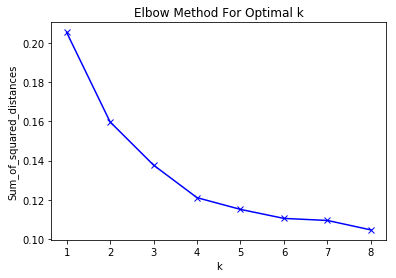

In [26]:
#First let's check the elbow method's output.
Sum_of_squared_distances = []
K = range(1,9)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(new_data_array)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### My second approach to validate is using 'Silhouette analysis'. It can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1]. Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. 

### As I can see the output below, cluster number 5 or number 4 are optimal choice, but actually when you see the scatter plot of cluster 4 there are 2 sub-groups inside of one larger cluster, therefore we can actually define cluster 5 as the best choice. 
### And also we can choose 5 as the best number because we validate this with "elbow method" above too.

## (Ref. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

Automatically created module for IPython interactive environment
For n_clusters = 3 The average silhouette_score is : 0.5942505890020829
For n_clusters = 4 The average silhouette_score is : 0.6805949924564406
For n_clusters = 5 The average silhouette_score is : 0.6321002460246617
For n_clusters = 6 The average silhouette_score is : 0.5081266823624657
For n_clusters = 7 The average silhouette_score is : 0.49117069502441335


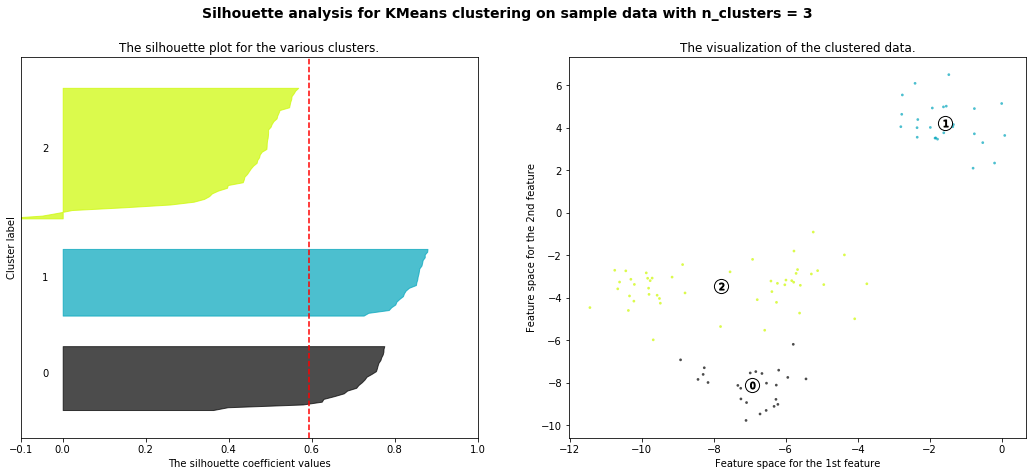

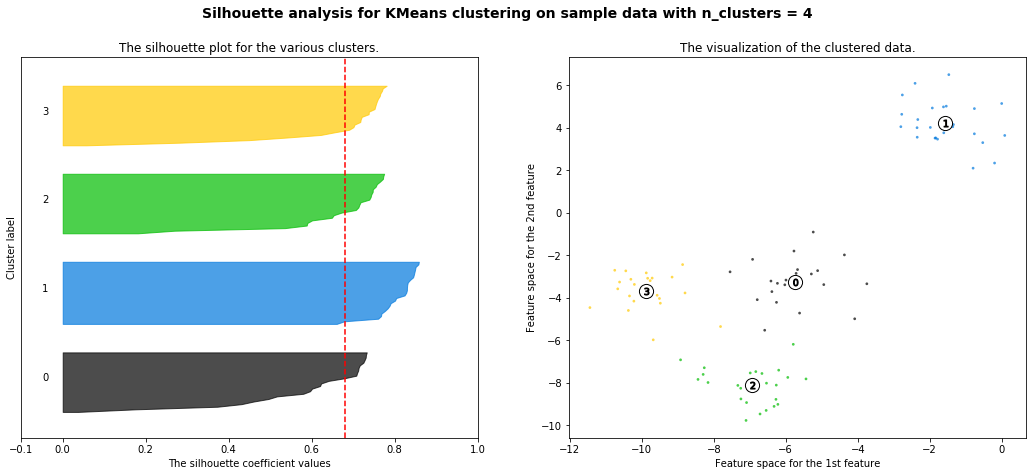

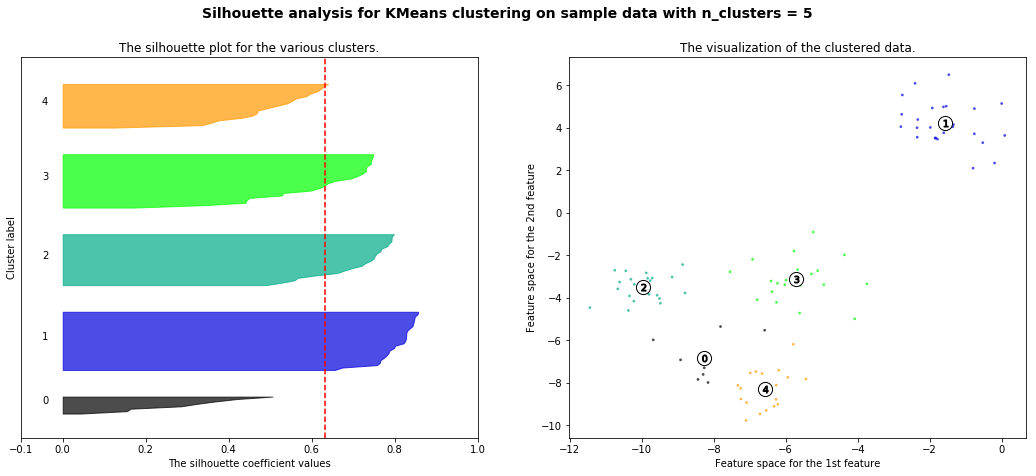

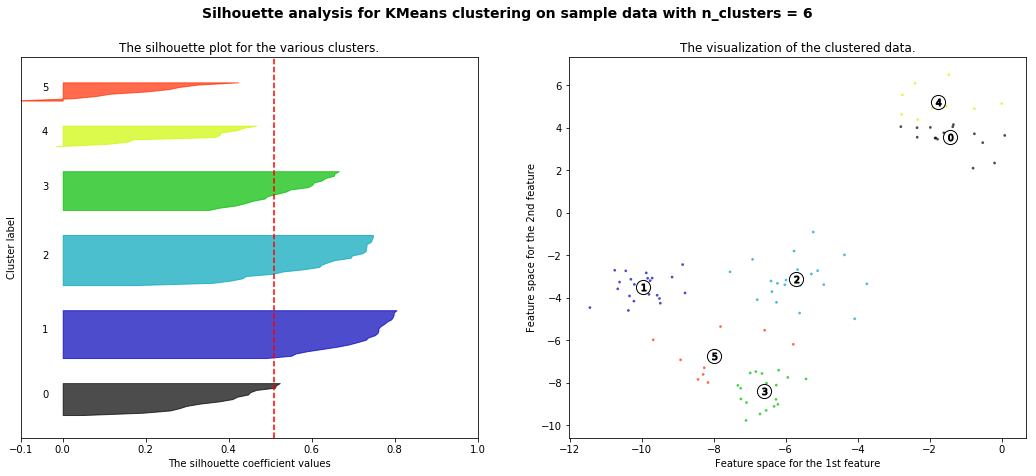

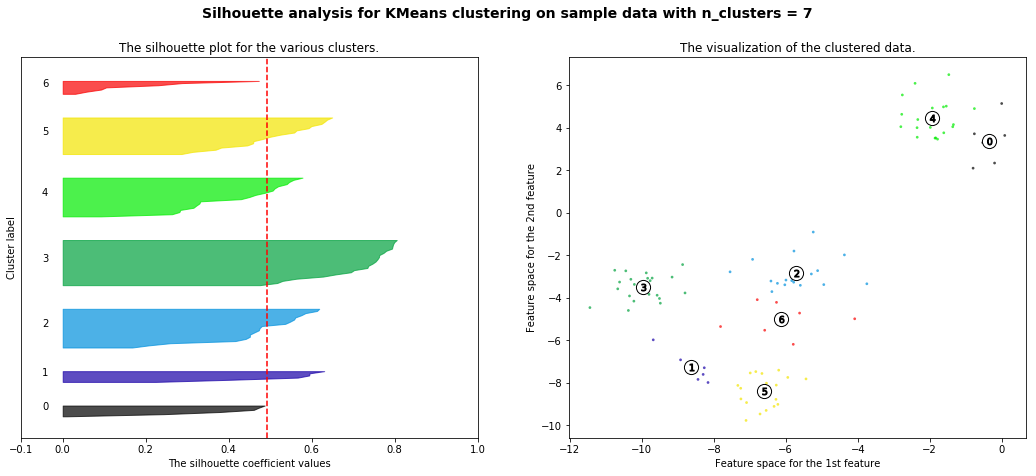

In [27]:
print(__doc__)
new_data_array_new= new_data_array
new_data_array_new, y = make_blobs(n_samples=len(new_data_array_new),
                  n_features=2,centers=4,cluster_std=1, center_box=(-10.0, 10.0),shuffle=True,random_state=1) 

range_n_clusters = [3,4,5,6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(new_data_array_new) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator, seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(new_data_array_new)
    # The silhouette_score gives the average value for all the samples. 
    #This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(new_data_array_new, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(new_data_array_new, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(new_data_array_new[:, 0], new_data_array_new[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [28]:
clusterer = KMeans(n_clusters=5,random_state=10)
cluster = clusterer.fit(new_data_array)
cluster_labels=cluster.predict(new_data_array)

In [29]:
print(cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=0)


In [30]:
cluster_labels

array([1, 1, 1, 1, 1, 4, 2, 3, 2, 3, 4, 4, 2, 2, 2, 4, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 4, 3, 2, 2, 4, 3, 3, 3,
       3, 3, 4, 2, 4, 4, 4, 2, 2, 3, 3, 2, 4, 2, 2, 2, 4, 3, 3, 3, 3, 2,
       1, 1, 1, 1, 1, 0, 0, 0, 2], dtype=int32)

In [31]:
# assign the cluster labels and make a new column

In [32]:
final_df['cluster_group'] = cluster_labels
final_df.head(3)

,model,category1,category2,frame,price_category,Albuquerque Cycles,Ann Arbor Speed,Austin Cruisers,Cincinnati Speed,Columbus Race Equipment,...,Phoenix Bi-peds,Pittsburgh Mountain Machines,Portland Bi-peds,Providence Bi-peds,San Antonio Bike Shop,San Francisco Cruisers,Seattle Race Equipment,Tampa 29ers,Wichita Speed,cluster_group
0,Bad Habit 1,Mountain,Trail,Aluminum,High,0.017483,0.006645,0.008130,0.005115,0.010152,...,0.011276,0.015915,0.01087,0.009225,0.021505,0.002674,0.015625,0.019417,0.005917,1
1,Bad Habit 2,Mountain,Trail,Aluminum,Low,0.006993,0.009967,0.004065,0.000000,0.000000,...,0.019027,0.002653,0.01087,0.023985,0.000000,0.002674,0.007812,0.000000,0.000000,1
2,Beast of the East 1,Mountain,Trail,Aluminum,High,0.010490,0.014950,0.008130,0.000000,0.000000,...,0.012685,0.005305,0.01087,0.009225,0.005376,0.000000,0.015625,0.009709,0.000000,1


## Step 3: Analyze the result

## Print out shop names that are in each segment

In [33]:
clusterer_bike = KMeans(n_clusters=5,random_state=10)
cluster_bike = clusterer_bike.fit(bikeshopname_df)
cluster_bike_labels=cluster_bike.predict(bikeshopname_df)
bikeshopname_df['cluster_group'] = cluster_bike_labels
bikeshopname_df.reset_index(inplace=True)
bikeshopname_df = bikeshopname_df.rename(columns={'index':'bikeshop_name'})
new_bikeshopname_df = bikeshopname_df[['bikeshop_name','cluster_group']]

### Print out shop names that are in each segment 

In [34]:
print("Print out shop names that are in each segment")
for i in range(0,len(set(new_bikeshopname_df['cluster_group'].values))) : 
    print("Cluster",i,"- Bike shop names : ",\
          str(new_bikeshopname_df.loc[(new_bikeshopname_df['cluster_group'] == i)]['bikeshop_name'].values.tolist())[1:-1])
    print('\n')

Print out shop names that are in each segment
Cluster 0 - Bike shop names :  'Ithaca Mountain Climbers', 'Pittsburgh Mountain Machines', 'Tampa 29ers'


Cluster 1 - Bike shop names :  'Ann Arbor Speed', 'Austin Cruisers', 'Indianapolis Velocipedes', 'Miami Race Equipment', 'Nashville Cruisers', 'New Orleans Velocipedes', 'Oklahoma City Race Equipment', 'Seattle Race Equipment'


Cluster 2 - Bike shop names :  'Cincinnati Speed', 'Columbus Race Equipment', 'Las Vegas Cycles', 'Louisville Race Equipment', 'San Francisco Cruisers', 'Wichita Speed'


Cluster 3 - Bike shop names :  'Albuquerque Cycles', 'Denver Bike Shop', 'Detroit Cycles', 'Kansas City 29ers', 'Los Angeles Cycles', 'Minneapolis Bike Shop', 'New York Cycles', 'Philadelphia Bike Shop', 'Phoenix Bi-peds', 'Portland Bi-peds', 'Providence Bi-peds', 'San Antonio Bike Shop'


Cluster 4 - Bike shop names :  'Dallas Cycles'




## Just verify the answer above by printing out dataframe table output 

In [35]:
new_bikeshopname_df.groupby(['cluster_group','bikeshop_name']).count()

Empty DataFrame
Columns: []
Index: [(0, Ithaca Mountain Climbers), (0, Pittsburgh Mountain Machines), (0, Tampa 29ers), (1, Ann Arbor Speed), (1, Austin Cruisers), (1, Indianapolis Velocipedes), (1, Miami Race Equipment), (1, Nashville Cruisers), (1, New Orleans Velocipedes), (1, Oklahoma City Race Equipment), (1, Seattle Race Equipment), (2, Cincinnati Speed), (2, Columbus Race Equipment), (2, Las Vegas Cycles), (2, Louisville Race Equipment), (2, San Francisco Cruisers), (2, Wichita Speed), (3, Albuquerque Cycles), (3, Denver Bike Shop), (3, Detroit Cycles), (3, Kansas City 29ers), (3, Los Angeles Cycles), (3, Minneapolis Bike Shop), (3, New York Cycles), (3, Philadelphia Bike Shop), (3, Phoenix Bi-peds), (3, Portland Bi-peds), (3, Providence Bi-peds), (3, San Antonio Bike Shop), (4, Dallas Cycles)]

## Determine the preferences of the shop segments by inspecting factors related to the model (e.g. price point, category of bike, etc.). To do this, you need to combine cluster centroids with bike models for feature inspection. Then for each cluster, arrange top 10 bike models by cluster in descending order and print out this information.

### First, to find out top 10 bike models by cluster in descending order,
### 1) I generate one more column named 'squared_dist' which actually calculate the distance to its own cluster center. Once I find out this distance, I can find which top 10 bike models are located nearest to the centroid of each cluster.

### 2) And as this squared distance value is smaller that means it is more close to centoird, which means more important value for each cluster. So I can order this distance column from smallest and select only first top 10 rows to print out

### Build a distance calculation method from each cluster's centroid

In [36]:
# In the new space, each dimension is the distance to the cluster centers --> Squared distance to cluster center
x_distance = cluster.transform(new_data_array)**2
distance_df= pd.DataFrame(x_distance.sum(axis=1).round(5), columns=['squared_dist'])
final_df['squared_dist'] = distance_df
final_df.head(2)

,model,category1,category2,frame,price_category,Albuquerque Cycles,Ann Arbor Speed,Austin Cruisers,Cincinnati Speed,Columbus Race Equipment,...,Pittsburgh Mountain Machines,Portland Bi-peds,Providence Bi-peds,San Antonio Bike Shop,San Francisco Cruisers,Seattle Race Equipment,Tampa 29ers,Wichita Speed,cluster_group,squared_dist
0,Bad Habit 1,Mountain,Trail,Aluminum,High,0.017483,0.006645,0.008130,0.005115,0.010152,...,0.015915,0.01087,0.009225,0.021505,0.002674,0.015625,0.019417,0.005917,1,0.01085
1,Bad Habit 2,Mountain,Trail,Aluminum,Low,0.006993,0.009967,0.004065,0.000000,0.000000,...,0.002653,0.01087,0.023985,0.000000,0.002674,0.007812,0.000000,0.000000,1,0.01323


In [37]:
preference_df = final_df.iloc[: ,[0,1,2,3,4,-2,-1]]

## Determine the preferences of the shop segments by inspecting factors related to the model  e.g. price point, category of bike, etc. 
## Answer is below : 
## Cluster 0 : High-end bikes for 'Mountain' riding, has 'High' price range, use 'Carbon' frame mostly. 
## Cluster 1 : Low-end bikes for 'Mountain' riding, has relatively 'Low' price range, use 'Aluminum' frame mostly. 
## Cluster 2 : Low-end bikes for 'Road' riding, has 'Low' price range, for 'Elite Road', 'Triathalon', and 'Endurance Road.
## Cluster 3 : High-end bikes for 'Road' riding, has 'High' price range, use 'Carbon' frame mostly. 
## Cluster 4 : Low-end bikes for 'Road' riding, has relatively 'Low' price range similar to Cluster 2, for 'Cyclocross', 'Elite Road'. 

## And, more detailed interpretation for each cluster is below :

In [57]:
## Interpretation by each cluster begins below :

## Cluster 0
### As I can see the result below, 
### Cluster 0's top ten bike models are all belongs to 'Mountain' category. Also  all of price is 'High'. And 9 out of 10 of them has 'Carbon' frame. So this cluster represents 'mountain' bike with 'high' price quality using 'Carbon' frame. This clustering output is really clear to understand group's preference and characteristic.

In [38]:
cluster0_df=preference_df[preference_df['cluster_group'] == 0]
cluster0_df.sort_values(by='squared_dist').iloc[:10,:]

,model,category1,category2,frame,price_category,cluster_group,squared_dist
24,F-Si Carbon 2,Mountain,Cross Country Race,Carbon,High,0,0.01116
44,Scalpel 29 Carbon 3,Mountain,Cross Country Race,Carbon,High,0,0.01257
27,F-Si Hi-Mod Team,Mountain,Cross Country Race,Carbon,High,0,0.01285
93,Trigger Carbon 1,Mountain,Over Mountain,Carbon,High,0,0.01288
36,Habit Carbon SE,Mountain,Trail,Carbon,High,0,0.01323
35,Habit Carbon 3,Mountain,Trail,Carbon,High,0,0.01348
47,Scalpel-Si Black Inc.,Mountain,Cross Country Race,Carbon,High,0,0.01365
38,Jekyll Carbon 1,Mountain,Over Mountain,Carbon,High,0,0.01370
28,Fat CAAD1,Mountain,Fat Bike,Aluminum,High,0,0.01378
48,Scalpel-Si Carbon 2,Mountain,Cross Country Race,Carbon,High,0,0.01396


## Cluster 1
### As I can see the result below, 
### Cluster 1's top ten bike models are also all belongs to 'Mountain' category. But this time, most of the price is 'Low'. And all of their frame is made of 'Aluminum'. So this cluster represents 'mountain' bike with relatively 'low' price and quality. 
### So interesting finding is, we can compare this group with cluster 0 group easily, because both of them are used for 'mountain' riding, but there price and quality segment is almost opposite. 

In [39]:
cluster1_df=preference_df[preference_df['cluster_group'] == 1]
cluster1_df.sort_values(by='squared_dist').iloc[:10,:]

,model,category1,category2,frame,price_category,cluster_group,squared_dist
46,Scalpel-Si 5,Mountain,Cross Country Race,Aluminum,High,1,0.00867
0,Bad Habit 1,Mountain,Trail,Aluminum,High,1,0.01085
22,F-Si 3,Mountain,Cross Country Race,Aluminum,Low,1,0.01158
31,Habit 5,Mountain,Trail,Aluminum,Low,1,0.01172
17,Catalyst 2,Mountain,Sport,Aluminum,Low,1,0.01188
42,Scalpel 29 4,Mountain,Cross Country Race,Aluminum,High,1,0.01205
29,Fat CAAD2,Mountain,Fat Bike,Aluminum,Low,1,0.01226
89,Trail 2,Mountain,Sport,Aluminum,Low,1,0.01231
16,Catalyst 1,Mountain,Sport,Aluminum,Low,1,0.01263
1,Bad Habit 2,Mountain,Trail,Aluminum,Low,1,0.01323


## Cluster 2
### Cluster 2's top ten bike models are all belongs to 'Road' category. Also most of price is 'Low'. And their frame is made of either 'Aluminum' or 'Carbon'. They are all 'Road' bike but belongs to mostly 'low' price group. Also this cluster's 'category2' shows variety of features including 'Elite Road', 'Triathalon', and 'Endurance Road'. So this group can be defined as 'Road' bike with low price but used for very different Road and Usage types.

In [40]:
cluster2_df=preference_df[preference_df['cluster_group'] == 2]
cluster2_df.sort_values(by='squared_dist').iloc[:10,:]

,model,category1,category2,frame,price_category,cluster_group,squared_dist
81,Synapse Disc Adventure,Road,Endurance Road,Aluminum,Low,2,0.01005
73,Synapse Carbon 105,Road,Endurance Road,Carbon,Low,2,0.01081
13,CAAD8 Claris,Road,Elite Road,Aluminum,Low,2,0.01139
53,Slice 105,Road,Triathalon,Carbon,Low,2,0.01234
69,Supersix Evo Tiagra,Road,Elite Road,Carbon,Low,2,0.01267
60,SuperX Rival CX1,Road,Cyclocross,Carbon,Low,2,0.01338
79,Synapse Claris,Road,Endurance Road,Aluminum,Low,2,0.01339
14,CAAD8 Sora,Road,Elite Road,Aluminum,Low,2,0.01485
77,Synapse Carbon Ultegra 3,Road,Endurance Road,Carbon,High,2,0.01486
61,SuperX Ultegra,Road,Cyclocross,Carbon,Low,2,0.01488


## Cluster 3 
### Cluster 3's top ten bike models are all belongs to 'Road' category. Also all of price is 'High'. And almost all of their frame is made of 'Carbon'. So this cluster represents 'Road' bike with 'High' price with high quality frame. So I can clearly see that this cluster is the most high-end group for 'Road' bike.

In [41]:
cluster3_df=preference_df[preference_df['cluster_group'] == 3]
cluster3_df.sort_values(by='squared_dist').iloc[:10,:]

,model,category1,category2,frame,price_category,cluster_group,squared_dist
85,Synapse Hi-Mod Disc Ultegra,Road,Endurance Road,Carbon,High,3,0.01132
59,SuperX Hi-Mod CX1,Road,Cyclocross,Carbon,High,3,0.01191
67,Supersix Evo Hi-Mod Utegra,Road,Elite Road,Carbon,High,3,0.01227
7,CAAD12 Black Inc,Road,Elite Road,Aluminum,High,3,0.01324
76,Synapse Carbon Disc Ultegra D12,Road,Endurance Road,Carbon,High,3,0.01333
66,Supersix Evo Hi-Mod Team,Road,Elite Road,Carbon,High,3,0.01371
83,Synapse Hi-Mod Disc Black Inc.,Road,Endurance Road,Carbon,High,3,0.01371
55,Slice Hi-Mod Dura Ace D12,Road,Triathalon,Carbon,High,3,0.01409
65,Supersix Evo Hi-Mod Dura Ace 2,Road,Elite Road,Carbon,High,3,0.01431
75,Synapse Carbon Disc Ultegra,Road,Endurance Road,Carbon,High,3,0.01435


## Cluster 4
### Cluster 4's top ten bike models are also all belongs to 'Road' category. Also 9 out of 10 model's price category belongs to 'Low'. And most of their frame is made of 'Carbon' but also they have lots of 'Aluminum' frame too. So they are 'Road' bike with mostly 'Low' price. 
### But one interesting feature for this cluster is, they are mainly used for 'Elite Road'. So I can compare this cluster with Cluster 2 who is also 'Road' bike with mostly 'Low' price but used for whole different category such as 'Elite Road', 'Triathalon', and 'Endurance Road'.

In [42]:
cluster4_df=preference_df[preference_df['cluster_group'] == 4]
cluster4_df.sort_values(by='squared_dist').iloc[:10,:]

,model,category1,category2,frame,price_category,cluster_group,squared_dist
58,SuperX 105,Road,Cyclocross,Carbon,Low,4,0.01157
62,Supersix Evo 105,Road,Elite Road,Carbon,Low,4,0.01243
72,Syapse Carbon Tiagra,Road,Endurance Road,Carbon,Low,4,0.01355
11,CAAD12 Ultegra,Road,Elite Road,Aluminum,Low,4,0.01467
68,Supersix Evo Red,Road,Elite Road,Carbon,High,4,0.01468
5,CAAD Disc Ultegra,Road,Elite Road,Aluminum,Low,4,0.01476
71,Supersix Evo Ultegra 4,Road,Elite Road,Carbon,Low,4,0.01492
78,Synapse Carbon Ultegra 4,Road,Endurance Road,Carbon,Low,4,0.01650
15,CAAD8 Tiagra,Road,Elite Road,Aluminum,Low,4,0.01666
82,Synapse Disc Tiagra,Road,Endurance Road,Aluminum,Low,4,0.01836


## Next, I apply 'Gaussian mixture model (GMM)' clustering 
## to compare the result with k-means clustering

### So GMM model is basically making un assumption that each data points sampled independently from a probability distribution, and for this time, I also give the same number of clusters with k-means which is 5 clusters. 
###  Compare to k-means, which does a "hard" assignment of each point to a cluster, the GMM algorithm does a "soft"  which is a "probabilistic"  assignment of each point to a cluster. Therefore, it is really meaningful to choose this model to compare these two different clustering techniques. 

### And the output was really interesting,
### Because basically every single cluster from GMM models matched with one of the cluster from k-means models shows having mostly identical characteristics and preferences, which means GMM and K-means applied different techniques to assign each data points into 5 groups, but they both found out key groups characteristic well without big difference from each other.

### All the detailed comparison and interperetation is below : 

In [43]:
from sklearn.mixture import GaussianMixture
gmm_model = GaussianMixture(n_components=5, n_init=1000, random_state=10)
gmm_model.fit(new_data_array)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1000,
                precisions_init=None, random_state=10, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [44]:
##  Cluster probabilities distribution

In [45]:
gmm_model.weights_ 

array([0.17525773, 0.15463918, 0.24742268, 0.15463918, 0.26804124])

In [46]:
gmm_cluster_predict = gmm_model.predict(new_data_array)

In [47]:
## ##  Cluster prediction label output

In [48]:
gmm_cluster_predict

array([2, 2, 2, 2, 2, 3, 1, 0, 1, 0, 1, 3, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 2, 4, 4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 2, 4, 4, 4, 4, 4, 4, 3, 0, 0, 1, 1, 3, 0, 3, 3, 3, 0, 0, 0,
       0, 0, 0, 3, 1, 1, 3, 3, 3, 0, 0, 1, 1, 3, 1, 3, 1, 0, 0, 0, 0, 1,
       2, 2, 2, 2, 2, 4, 4, 4, 1])

In [49]:
preference_df['gmm_cluster_group'] = gmm_cluster_predict
gmm_preference_df= preference_df.iloc[:,[0,1,2,3,4,7]]

## Cluster 0
### In the GMM model's output, Cluster 0 represents 'Road' bike with 'High' price category and most of them built with 'Carbon' frame. 
### I can find out that this characteristic is almost similar to Cluster 3 group's trait  of K-means clustering output. So we can get the idea that both of the models perform well to define cluster's characteristic using different technique of cluster assignment.

In [50]:
gmm_cluster0_df=gmm_preference_df[gmm_preference_df['gmm_cluster_group'] == 0]
gmm_cluster0_df[:10]

,model,category1,category2,frame,price_category,gmm_cluster_group
7,CAAD12 Black Inc,Road,Elite Road,Aluminum,High,0
9,CAAD12 Disc Dura Ace,Road,Elite Road,Aluminum,High,0
54,Slice Hi-Mod Black Inc.,Road,Triathalon,Carbon,High,0
55,Slice Hi-Mod Dura Ace D12,Road,Triathalon,Carbon,High,0
59,SuperX Hi-Mod CX1,Road,Cyclocross,Carbon,High,0
63,Supersix Evo Black Inc.,Road,Elite Road,Carbon,High,0
64,Supersix Evo Hi-Mod Dura Ace 1,Road,Elite Road,Carbon,High,0
65,Supersix Evo Hi-Mod Dura Ace 2,Road,Elite Road,Carbon,High,0
66,Supersix Evo Hi-Mod Team,Road,Elite Road,Carbon,High,0
67,Supersix Evo Hi-Mod Utegra,Road,Elite Road,Carbon,High,0


## Cluster 1
### In the GMM model's output, Cluster 1 represents 'Road' bike with relatively 'Low' price than Cluster 0, and their frame is made of either 'Aluminum' or 'Carbon'. Also this cluster's 'category2' shows variety of features including 'Elite Road', 'Triathalon', and 'Endurance Road'. So this group can be defined as 'Road' bike with low price but used for very different Road and Usage types.

### I can find out that this characteristic is almost similar to Cluster 2 group's trait  of K-means clustering. So we can get the idea that both of the models perform well to define cluster's characteristic using different technique of cluster assignment in this cluster case too.


In [51]:
gmm_cluster1_df=gmm_preference_df[gmm_preference_df['gmm_cluster_group'] == 1]
gmm_cluster1_df[:10]

,model,category1,category2,frame,price_category,gmm_cluster_group
6,CAAD12 105,Road,Elite Road,Aluminum,Low,1
8,CAAD12 Disc 105,Road,Elite Road,Aluminum,Low,1
10,CAAD12 Red,Road,Elite Road,Aluminum,High,1
13,CAAD8 Claris,Road,Elite Road,Aluminum,Low,1
15,CAAD8 Tiagra,Road,Elite Road,Aluminum,Low,1
56,Slice Ultegra,Road,Triathalon,Carbon,High,1
57,Slice Ultegra D12,Road,Triathalon,Carbon,High,1
70,Supersix Evo Ultegra 3,Road,Elite Road,Carbon,High,1
71,Supersix Evo Ultegra 4,Road,Elite Road,Carbon,Low,1
77,Synapse Carbon Ultegra 3,Road,Endurance Road,Carbon,High,1


## Cluster 2
### In the GMM model's output, Cluster 2 represents 'Mountain' bike with mostly 'Low' price and their frame is made of 'Aluminum'. So this cluster represents 'mountain' bike with relatively 'low' price and quality. 

### I can find out that this characteristic is almost similar to Cluster 1 group's trait  of K-means clustering. So we can get the idea that both of the models perform well to define cluster's characteristic using different technique of cluster assignment in this cluster case too.


In [52]:
gmm_cluster2_df=gmm_preference_df[gmm_preference_df['gmm_cluster_group'] == 2]
gmm_cluster2_df[:10]

,model,category1,category2,frame,price_category,gmm_cluster_group
0,Bad Habit 1,Mountain,Trail,Aluminum,High,2
1,Bad Habit 2,Mountain,Trail,Aluminum,Low,2
2,Beast of the East 1,Mountain,Trail,Aluminum,High,2
3,Beast of the East 2,Mountain,Trail,Aluminum,Low,2
4,Beast of the East 3,Mountain,Trail,Aluminum,Low,2
16,Catalyst 1,Mountain,Sport,Aluminum,Low,2
17,Catalyst 2,Mountain,Sport,Aluminum,Low,2
18,Catalyst 3,Mountain,Sport,Aluminum,Low,2
19,Catalyst 4,Mountain,Sport,Aluminum,Low,2
20,F-Si 1,Mountain,Cross Country Race,Aluminum,Low,2


## Cluster 3
### In the GMM model's output, Cluster 3 represents 'Road' bike with 'Low' price and their frame is made of either 'Aluminum' or 'Carbon'. So this cluster represents 'Road' bike with 'low' price and quality. 

### I can find out that this characteristic is almost similar to Cluster 4 group's trait  of K-means clustering. Because both of them used for different category including ' Elite Road','Triathalon' and 'Cyclocross'. 

In [53]:
gmm_cluster3_df=gmm_preference_df[gmm_preference_df['gmm_cluster_group'] == 3]
gmm_cluster3_df[:10]

,model,category1,category2,frame,price_category,gmm_cluster_group
5,CAAD Disc Ultegra,Road,Elite Road,Aluminum,Low,3
11,CAAD12 Ultegra,Road,Elite Road,Aluminum,Low,3
12,CAAD8 105,Road,Elite Road,Aluminum,Low,3
14,CAAD8 Sora,Road,Elite Road,Aluminum,Low,3
53,Slice 105,Road,Triathalon,Carbon,Low,3
58,SuperX 105,Road,Cyclocross,Carbon,Low,3
60,SuperX Rival CX1,Road,Cyclocross,Carbon,Low,3
61,SuperX Ultegra,Road,Cyclocross,Carbon,Low,3
62,Supersix Evo 105,Road,Elite Road,Carbon,Low,3
69,Supersix Evo Tiagra,Road,Elite Road,Carbon,Low,3


## Cluster 4
### In the GMM model's output, Cluster 4 represents 'Mountain' bike with 'High' price and their frame is made of mostly 'Carbon'. So this cluster represents 'Moutain' bike with 'High' price and quality. 
### I can also find out that this characteristic is almost similar to Cluster 0 group's trait  of K-means clustering. So very interesting finding in this step was, basically all of those 5 clusters from two different models matched each other including mostly identical characteristics.


In [54]:
gmm_cluster4_df=gmm_preference_df[gmm_preference_df['gmm_cluster_group'] == 4]
gmm_cluster4_df[:10]

,model,category1,category2,frame,price_category,gmm_cluster_group
23,F-Si Black Inc.,Mountain,Cross Country Race,Carbon,High,4
24,F-Si Carbon 2,Mountain,Cross Country Race,Carbon,High,4
26,F-Si Hi-Mod 1,Mountain,Cross Country Race,Carbon,High,4
27,F-Si Hi-Mod Team,Mountain,Cross Country Race,Carbon,High,4
28,Fat CAAD1,Mountain,Fat Bike,Aluminum,High,4
33,Habit Carbon 1,Mountain,Trail,Carbon,High,4
34,Habit Carbon 2,Mountain,Trail,Carbon,High,4
35,Habit Carbon 3,Mountain,Trail,Carbon,High,4
36,Habit Carbon SE,Mountain,Trail,Carbon,High,4
37,Habit Hi-Mod Black Inc.,Mountain,Trail,Carbon,High,4


## GMM Clustering output Visualization

### Ref) https://python-graph-gallery.com/372-3d-pca-result/ 
### Refer and modify some part of visualization codes from this webpage 

In [55]:
# GMM model's output visualization steps
new_data_array_df=pd.DataFrame(new_data_array)
gmm_model_visulization = GaussianMixture(n_components=5, n_init=1000, random_state=10)
gmm_model_visulization.fit(new_data_array_df)
#Getting the cluster labels
labels = gmm_model_visulization.predict(new_data_array_df)
new_data_array_df["gmm_cluster"] = labels
# PCA into 3 dimention -  dimention reduction
pca = PCA(n_components=3).fit(new_data_array_df)
pca_3d = pca.transform(new_data_array_df)
gmm_pca_df =pd.DataFrame(pca.transform(new_data_array_df), columns=['PC%i' % i for i in range(3)],\
                         index=new_data_array_df.index) 

Text(0.5,0.92,"Visualization GMM Model's 5 clusters on 3d PCA ")

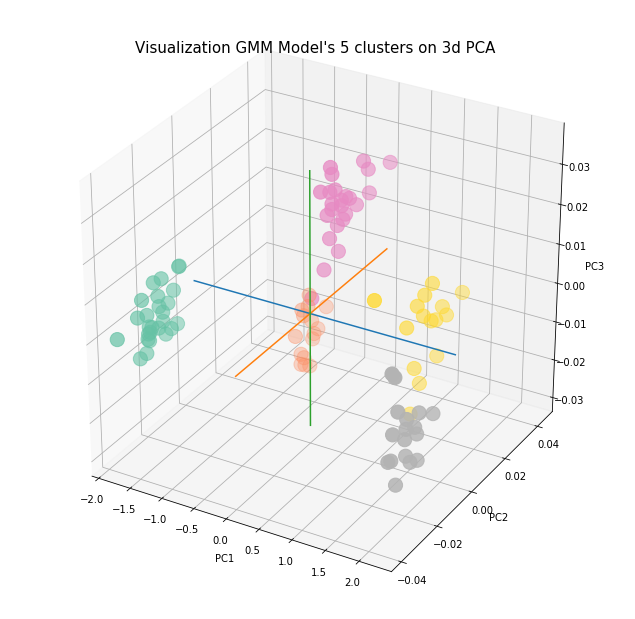

In [56]:
# Plot initialisation
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gmm_pca_df['PC0'], gmm_pca_df['PC1'], gmm_pca_df['PC2'],c=labels,cmap="Set2_r", s=200)
xaxis = ((min(gmm_pca_df['PC0']), max(gmm_pca_df['PC0'])), (0, 0), (0,0))
ax.plot(xaxis[0], xaxis[1], xaxis[2])
yaxis = ((0, 0), (min(gmm_pca_df['PC1']), max(gmm_pca_df['PC1'])), (0,0))
ax.plot(yaxis[0], yaxis[1], yaxis[2])
zaxis = ((0, 0), (0,0), (min(gmm_pca_df['PC2']), max(gmm_pca_df['PC2'])))
ax.plot(zaxis[0], zaxis[1], zaxis[2])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Visualization GMM Model's 5 clusters on 3d PCA ", fontsize=15)